# COCO Object Detection using DreamAI

## Imports

In [1]:
import sys

# Make sure to change these paths to your folders with the COCO API and DreamAI

sys.path.insert(0, '/home/farhan/hamza/Coco/cocoapi-master/PythonAPI') # Folder with the COCO API
from pycocotools.coco import COCO
sys.path.insert(0, '/home/farhan/hamza/dreamai/') # Folder with DreamAI

# Things below are all included in the dreamai folder

import cv_model
import utils
import obj_utils
from dai_imports import*

%load_ext autoreload
%autoreload 2

Your coco dataset folder should look something like this:

![title](coco_folder.png)

Setup the necessary paths.

All the dataframes after the train,val,test split will be saved in the folder with the coco dataset. All the best model files wil be saved in the current directory by default.

'train_name' is the folder with ALL of the images. DreamAI requires all of the images to be in one single folder.

If the data is in the Keras format, that will be handled in the DataProcessor function below. But that is not the case here, I will demonstrate that on some other dataset.

In [2]:
data_path = Path('/home/farhan/hamza/Coco_github/')
train_name = 'train2017'
val_name = 'val'
test_name = 'test'
csv_name = 'dai_coco.csv'
dp_name = 'DP_obj_coco.pkl'
ann_file = data_path/'annotations/instances_{}.json'.format(train_name)
train_path = data_path/train_name
val_path = data_path/val_name
test_path = data_path/test_name
csv_path = data_path/csv_name
dp_path = data_path/dp_name

## Utility Functions

In [3]:
def draw_im(im, ann, cat_dict):
    ax = obj_utils.img_grid(im, figsize=(16,16))
    for a in ann:
        obj_utils.draw_rect(ax, a['bbox'])
        obj_utils.draw_text(ax, a['bbox'][:2], cat_dict[a['category_id']]['name'], sz=16)

def get_box_name(ann,cat_dict):
    box = []
    name = []
    for a in ann:
        box.append(obj_utils.hw_bb(a['bbox']))
        name.append(cat_dict[a['category_id']]['name'])
    return (box,name)

def get_box_name_str(ann,cat_dict):
    
    b,n = get_box_name(ann=ann,cat_dict=cat_dict)
    n = ' '.join(n)
    b2 = []
    for x in b:
        b2+=x
    b2 = [str(x) for x in b2]
    b2 = ' '.join(b2)
    return b2,n

## Data Setup

This code will use the coco api and create a pandas dataframe with 3 columns:
- 'img' for image file name.
- 'bbox' for bounding boxes in each image. Each row will have a single string with all coordinates separated by a space.
- 'name' for the names of the objects in each image. Also space separated.

After that, we will use DreamAI's data processor to extract relevant information as well as split the data into train,val,and test.

Everything under the 'Data Setup' heading should be run only once, after that you can comment this part out and start with 'Load Data'.

In [ ]:
# Initialize COCO api for instance annotations
coco=COCO(ann_file)

# Load images and annotations

cats = coco.loadCats(coco.getCatIds())
cat_dict = {c['id']:c for c in cats}
imgs = coco.loadImgs(coco.getImgIds())
anns = [coco.loadAnns(coco.getAnnIds(img['id'])) for img in imgs]

# Remove images with no annoations

good_idx = [i for i,a in enumerate(anns) if len(a) > 0]
imgs = np.array(imgs)[good_idx]
anns = np.array(anns)[good_idx]

# Get bounding boxes

imgs_paths = [train_path/img['file_name'] for img in imgs]
imgs_ids = [img['file_name'] for img in imgs]

bboxs_names = np.array([get_box_name_str(ann,cat_dict) for ann in anns])
bboxs = bboxs_names[:,0]
names = bboxs_names[:,1]

# Remove images where the number of object names in an image and the number of bounding boxes do not match

b_lens = np.array([len(b.split())//4 for b in bboxs])
n_lens = np.array([len(n.split()) for n in names])
mask = b_lens == n_lens
bboxs = np.array(bboxs)[mask]
names = np.array(names)[mask]
imgs_ids = np.array(imgs_ids)[mask]

# Create dataframe

df_data = {'img':imgs_ids,'bbox':bboxs,'name':names}
df = pd.DataFrame(data = df_data)
df.to_csv(csv_path,index=False)
df.head()

Now we pass our dataframe to DataProcessor and save the returned object with all the information about the data. This will take a while because of the dataset's size.

In [ ]:
DP = data_processing.DataProcessor(data_path=data_path,train_csv=csv_name,tr_name=train_name,setup_data=True)

data_processing.save_obj(DP,dp_path)

## Load and Use the Data

In [4]:
# Load our saved DataProcessor object

DP = data_processing.load_obj(dp_path)

In [5]:
# Dictionary with information about the data

data_dict = DP.data_dict

Boungin boxes are all of the same length i.e, max length and zeros are filled.

Name is one-hot encoded.

In [6]:
data_dict['data_dfs'][train_name].head()

img                                               bbox  \
0  000000396866.jpg  [tensor(0.), tensor(0.), tensor(0.), tensor(0....   
1  000000568330.jpg  [tensor(0.), tensor(0.), tensor(0.), tensor(0....   
2  000000049283.jpg  [tensor(0.), tensor(0.), tensor(0.), tensor(0....   
3  000000509490.jpg  [tensor(0.), tensor(0.), tensor(0.), tensor(0....   
4  000000287006.jpg  [tensor(0.), tensor(0.), tensor(0.), tensor(0....   

                                                name  
0  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
1  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
2  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
3  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
4  [tensor(0), tensor(0), tensor(0), tensor(0), t...

In [7]:
data_dict['data_dfs'][val_name].head()

img                                               bbox  \
0  000000438560.jpg  [tensor(0.), tensor(0.), tensor(0.), tensor(0....   
1  000000079357.jpg  [tensor(0.), tensor(0.), tensor(0.), tensor(0....   
2  000000509388.jpg  [tensor(0.), tensor(0.), tensor(0.), tensor(0....   
3  000000077481.jpg  [tensor(0.), tensor(0.), tensor(0.), tensor(0....   
4  000000284648.jpg  [tensor(0.), tensor(0.), tensor(0.), tensor(0....   

                                                name  
0  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
1  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
2  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
3  [tensor(0), tensor(0), tensor(0), tensor(0), t...  
4  [tensor(0), tensor(0), tensor(0), tensor(0), t...

In [8]:
image_size = (256,256)
bs = 32

In [9]:
# Create dataset and dataloaders

sets,loaders,sizes = DP.get_data(data_dict, image_size, bs = bs)

In [10]:
sizes

{'train2017': 67936, 'val': 10190, 'test': 1799}

In [11]:
# Number of batches to print progress after

print_every = sizes[train_name]//3//bs
print_every

707

## Model Setup

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = cv_model.CustomSSDObjectDetection(model_name = 'resnet50', one_cycle_factor = None,
                            optimizer_name = 'sgd', device = device,
                            best_model_file = 'best_custom_ssd_coco_resnet50_sgd_github.pth',
                            class_names = data_dict['class_names'], num_classes = data_dict['num_classes'],
                            image_size = image_size, dropout_p = 0.5, add_extra = False)

Setting transfer learning model: self.model set to resnet50
Grids: [8, 4, 2, 1]
resnet50: setting head: CustomSSD_MultiHead
Transfer Learning: current best accuracy = 0.000
Setting optimizer: SGD


Uncomment these lines when you want to retrain or just use the model for predictions.

In [ ]:
# net.load_state_dict(torch.load('best_custom_ssd_coco_resnet50_sgd_github.pth'))
# net.optimizer.load_state_dict(torch.load('best_custom_ssd_coco_resnet50_sgd_github_optim.pth'))

In [ ]:
net.unfreeze()

In [ ]:
# Find and set the ideal learning rate

lr = net.find_lr(loaders[train_name],plot=True)
net.optimizer.param_groups[0]['lr'] = lr
net.optimizer.param_groups[0]['lr']

## Train

In [ ]:
net.fit(loaders[train_name], loaders[val_name], epochs = 70, print_every = print_every)

## Show Results

/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/home/farhan/anaconda3/envs/dreamai/lib/python3.7/site-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTenso

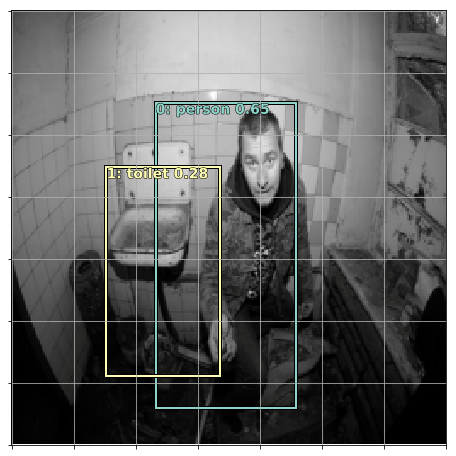

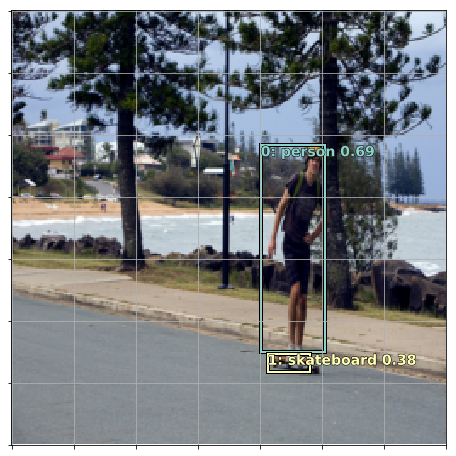

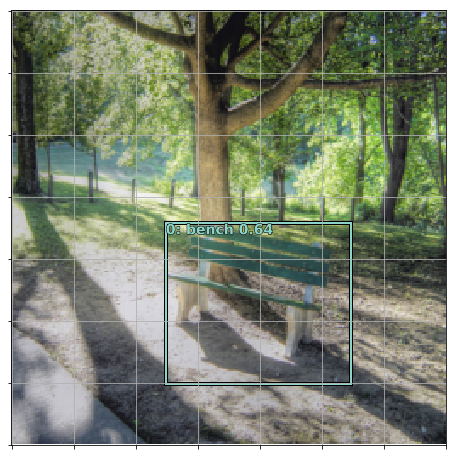

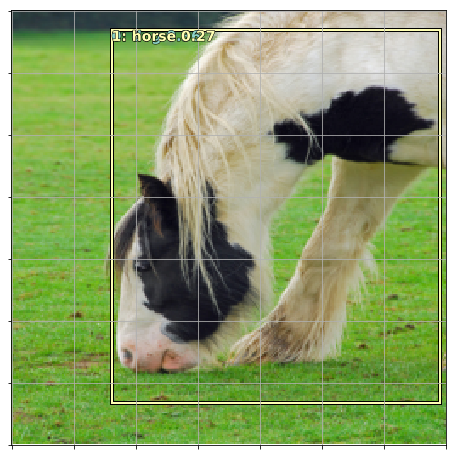

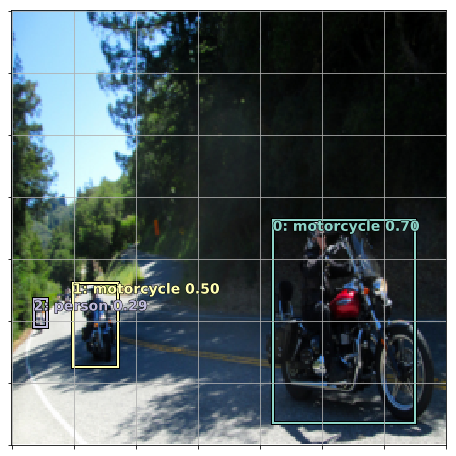

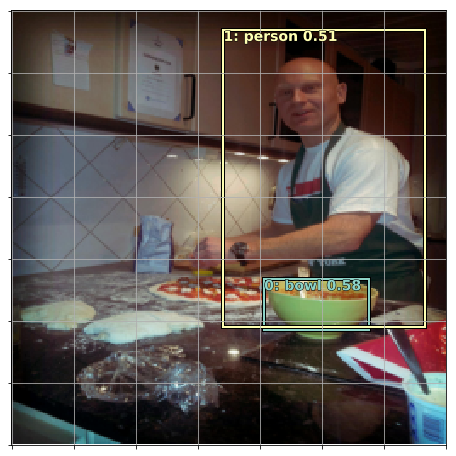

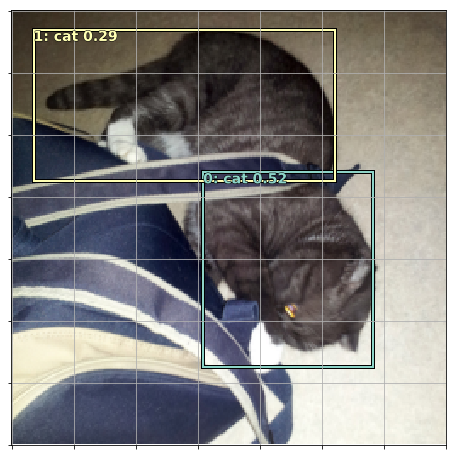

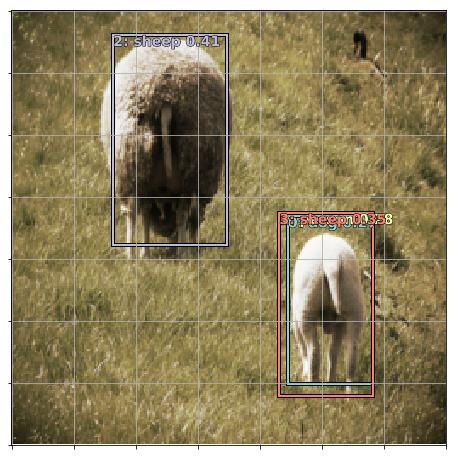

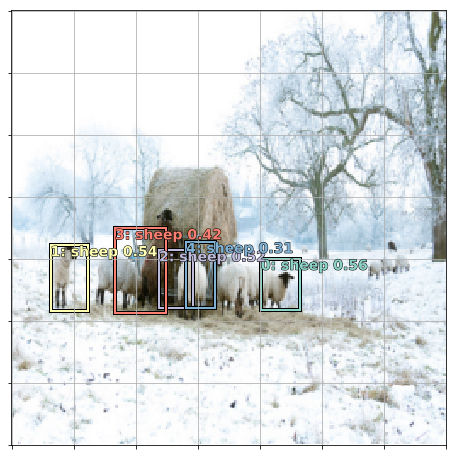

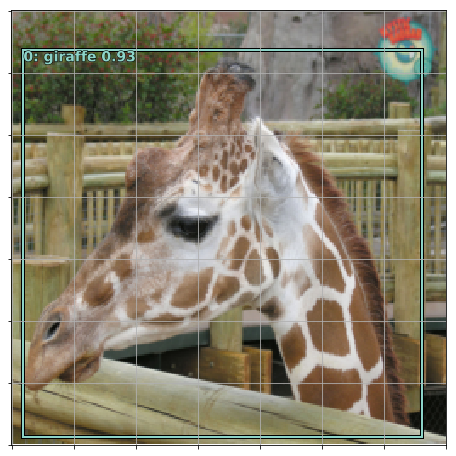

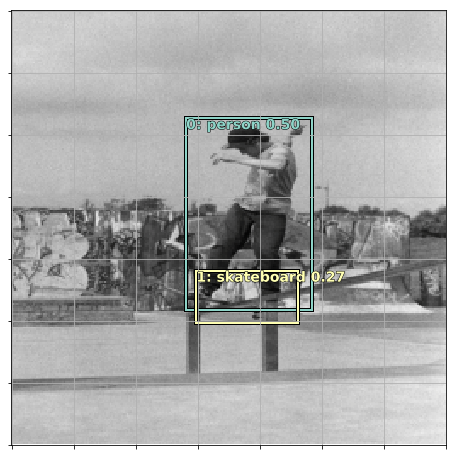

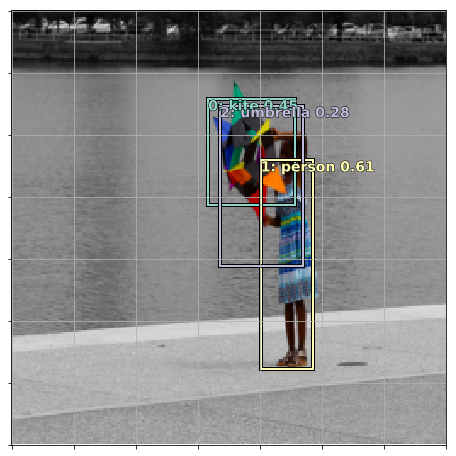

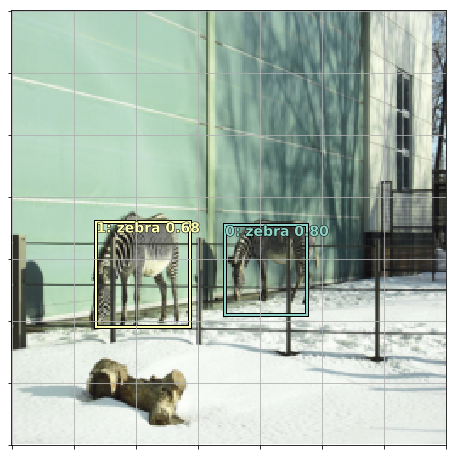

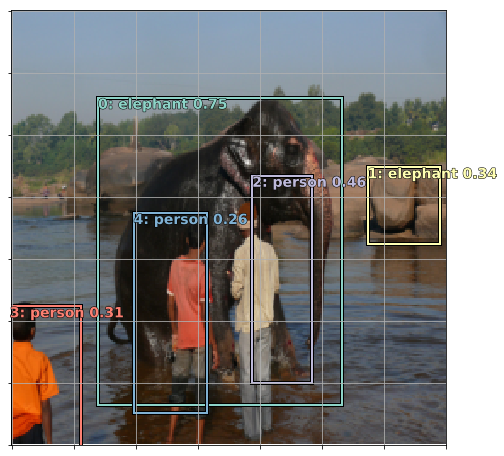

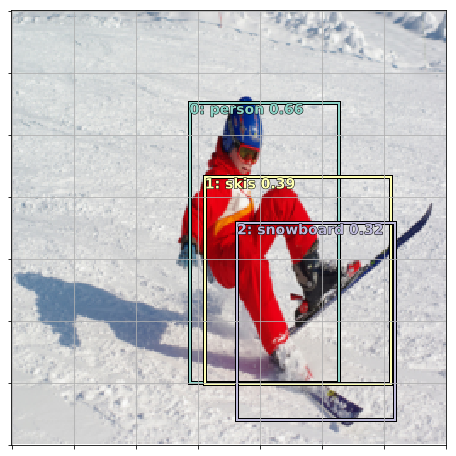

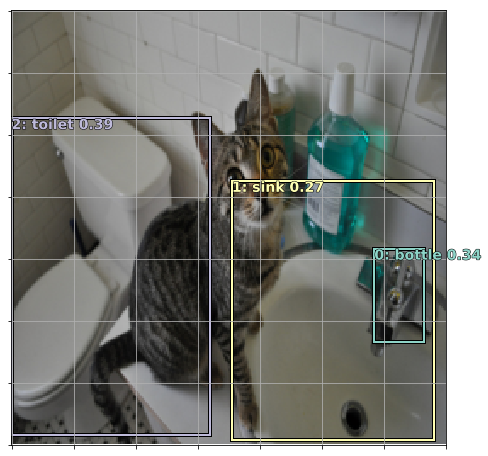

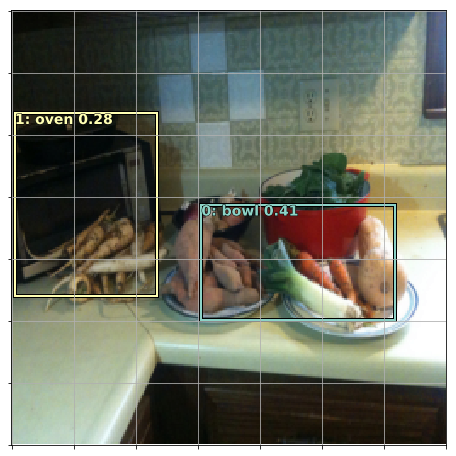

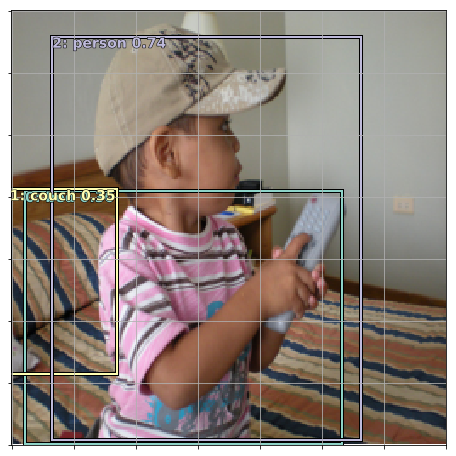

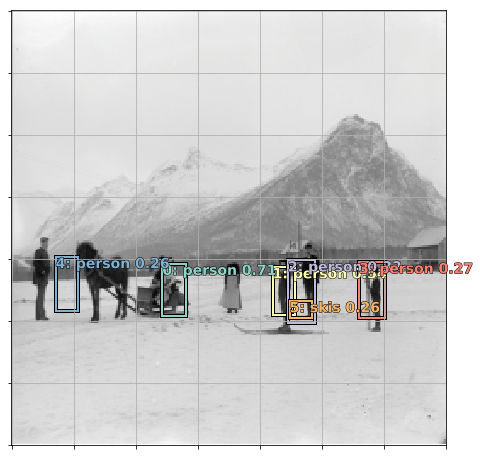

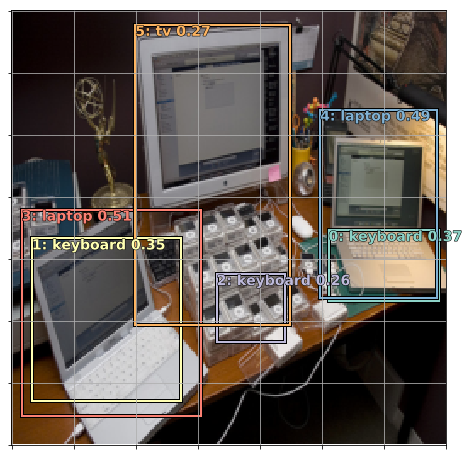

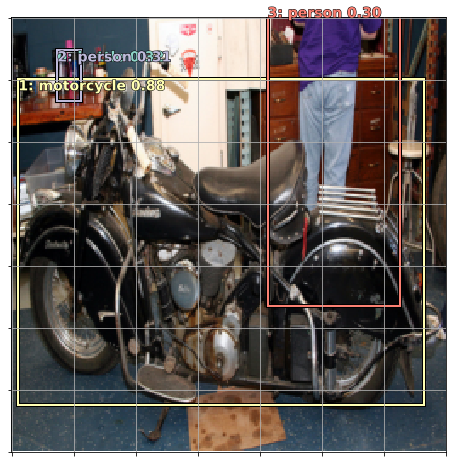

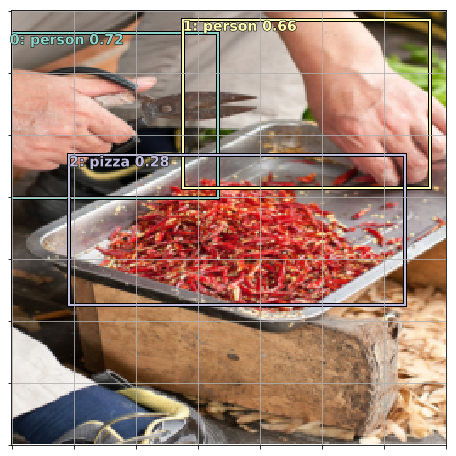

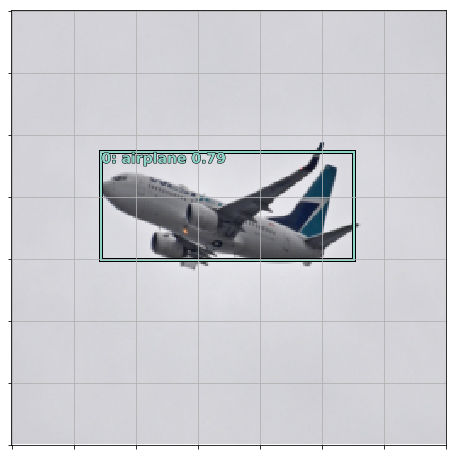

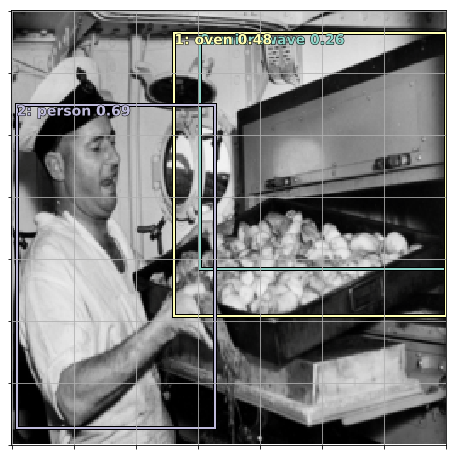

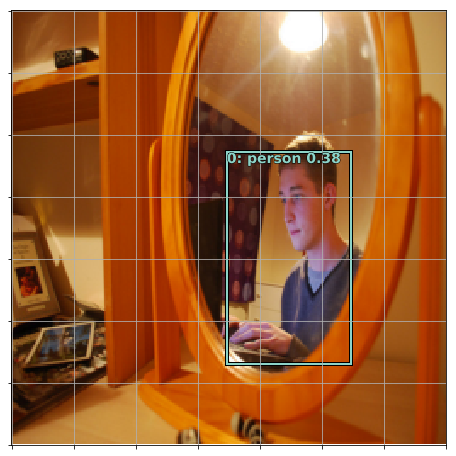

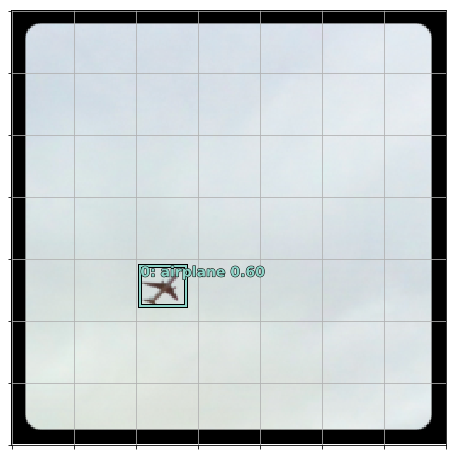

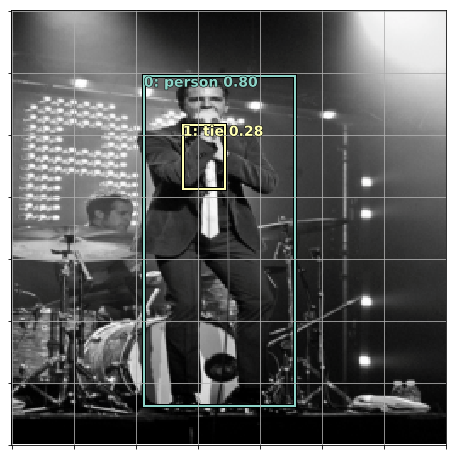

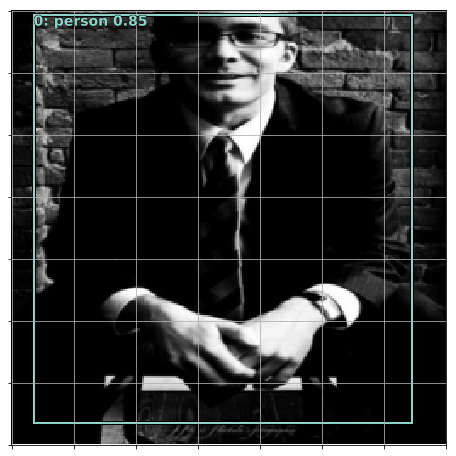

In [22]:
net.show_nms(loader = loaders[test_name], num = 30, dp = DP, score_thresh = 0.25, nms_overlap = 0.4)

There are several ways to improve these results such as hyperparameter tuning and adding more data, but as you can see, our model is pretty good and can act as a general object detection backbone to use for transfer learning in more specific tasks.